In [2]:
!pip install pyathena


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from pyathena import connect
import pandas as pd

In [4]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'viamericas'
database_name2= 'analytics'
table1_name = 'forex_feed_market'
table2_name = 'daily_check'
##DAILY CHECK IS THE DATABASE VALIDATED WITH THE CLIENT, IT DOES NOT COUNT CANCELLATIONS OR VIRTUAL AGENCIES##

In [5]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)

/tmp/ipykernel_5222/1299455614.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df2 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)


In [6]:
df2.shape

(101970, 5)

In [7]:
df2.head()

,payer,country,date,tx,amount
0,BANCO GANADERO (BOLIVIA),BOLIVIA,2023-04-13,0,0.00
1,CARIBE EXPRESS,DOMINICAN REPUBLIC,2023-01-23,1117,350050.40
2,GRUPO EXITO (TN),COLOMBIA,2023-01-23,247,52423.90
3,BANPAIS (RED CHAPINA),HONDURAS,2022-10-31,146,59000.50
4,TELECOMM TELEGRAFOS (APPRIZA),MEXICO,2022-05-15,1062,640446.24


In [8]:
##TO SPEED UP THE LOADING, WE ALREADY WORK WITH THE EXTRACTED CSV##

In [9]:
df1=pd.read_csv('rates_completo.csv')

In [10]:
df1.symbol.unique()

array(['USDBRL', 'USDINR', 'USDGTQ', 'USDMXN', 'USDPHP'], dtype=object)

In [11]:
##WE FILTER DATA FOR MEXICO##

In [12]:
df_mex=df1.loc[df1.symbol=='USDMXN']

In [13]:
##WE OBTAIN THE LAST VALUE OF THE EXCHANGE RATE OF EACH DAY ##

/tmp/ipykernel_5222/394912117.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['feed_date'] = pd.to_datetime(data['feed_date'])


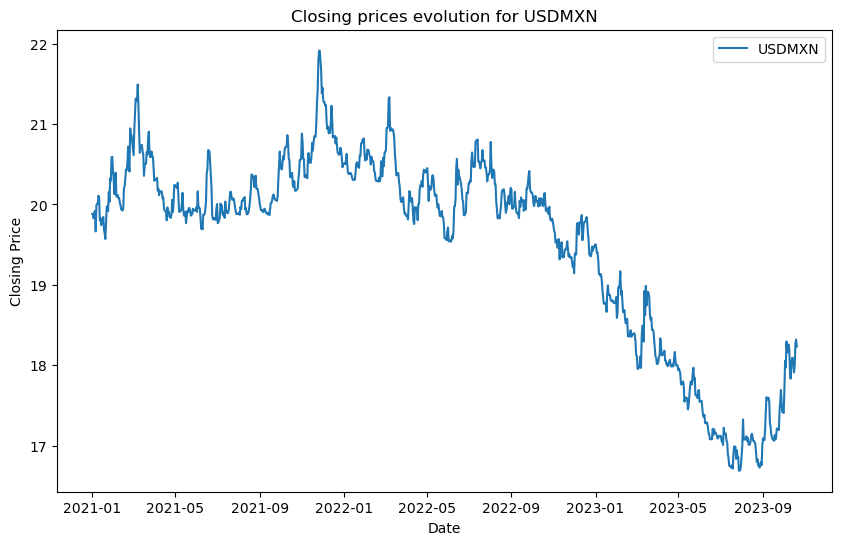

      symbol  feed_date  feed_price
0     USDMXN 2021-01-01     19.8822
1     USDMXN 2021-01-02     19.8822
2     USDMXN 2021-01-03     19.8282
3     USDMXN 2021-01-04     19.9046
4     USDMXN 2021-01-05     19.9196
...      ...        ...         ...
1018  USDMXN 2023-10-16     17.9119
1019  USDMXN 2023-10-17     18.0094
1020  USDMXN 2023-10-18     18.2726
1021  USDMXN 2023-10-19     18.3207
1022  USDMXN 2023-10-20     18.2351

[1023 rows x 3 columns]


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime type if it is not already
    data['feed_date'] = pd.to_datetime(data['feed_date'])

    # Filter by date range
    data_filtered = data[(data['feed_date'] >= start_date) & (data['feed_date'] <= end_date)]

    # Sort by 'FEED_DATE' to ensure that the data is in chronological order
    data_filtered = data_filtered.sort_values(by='feed_date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='feed_date', freq='D')])['feed_price'].last().reset_index()

    # Generate evolution plots for each SYMBOL
    for symbol in data_grouped['symbol'].unique():
        symbol_data = data_grouped[data_grouped['symbol'] == symbol]

        plt.figure(figsize=(10, 6))
        plt.plot(symbol_data['feed_date'], symbol_data['feed_price'], label=symbol)
        plt.title(f'Closing prices evolution for {symbol}')
        plt.xlabel('Date')
        plt.ylabel('Closing Price')
        plt.legend()
        plt.show()

    return data_grouped

# Using the function
# Suppose your DataFrame is named df
# Adjust the dates according to your needs
start_date = '2021-01-01'
end_date = '2023-10-21'

rates = get_closing_prices(df_mex, start_date, end_date)
print(rates)

In [15]:
rates.head(3)

,symbol,feed_date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-03,19.8282


In [16]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101970 entries, 0 to 101969
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   payer    101970 non-null  object 
 1   country  101970 non-null  object 
 2   date     101970 non-null  object 
 3   tx       101970 non-null  int64  
 4   amount   101970 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 3.9+ MB


In [17]:
df2.amount.sum()

25110624454.414898

In [18]:
df2['date'] = pd.to_datetime(df2['date'])

In [19]:
##WE MERGE THE DATASETS TO HAVE TRADED AMOUNTS AND EXCHANGE RATES PER DAY##

In [20]:
rates = rates.rename(columns={'feed_date': 'date'})
rates['date'] = pd.to_datetime(rates['date'])

rates.head()

,symbol,date,feed_price
0,USDMXN,2021-01-01,19.8822
1,USDMXN,2021-01-02,19.8822
2,USDMXN,2021-01-03,19.8282
3,USDMXN,2021-01-04,19.9046
4,USDMXN,2021-01-05,19.9196


In [21]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 

In [22]:
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates[nombre_columna] = rates['feed_price'].shift(i)

In [23]:
rates.head(3)

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,USDMXN,2021-01-01,19.8822,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USDMXN,2021-01-02,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN,NaN
2,USDMXN,2021-01-03,19.8282,19.8822,19.8822,NaN,NaN,NaN,NaN,NaN


In [24]:
##FILTERING MEXICO##

In [25]:
df_montos_mex=df2.loc[df2.country=='MEXICO']

In [26]:
df_montos_mex.shape

(22705, 5)

In [27]:
df_montos_mex.amount.sum()

13655009099.1769

In [28]:
###WE MERGE THE RESULTING DATABASE WITH THE DATABASE OF RATES##

In [29]:
df_final=pd.merge(df_montos_mex, rates, on='date', how='left')

In [30]:
df_final.head(3)

,payer,country,date,tx,amount,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
0,TELECOMM TELEGRAFOS (APPRIZA),MEXICO,2022-05-15,1062,640446.24,USDMXN,20.1224,20.1063,20.1075,20.1817,20.3206,20.3631,20.3550,20.2129
1,WALMART (UT),MEXICO,2022-11-07,648,250102.77,USDMXN,19.4623,19.5597,19.5258,19.5258,19.6515,19.6729,19.7309,19.7945
2,OXXO (TN),MEXICO,2022-09-01,243,17821.36,USDMXN,20.1845,20.2070,20.1354,20.0025,20.1031,20.0226,20.0258,19.9375


In [31]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## WE WILL NOW FIT A MODEL WITH LAGS OF THE EXCHANGE RATE (SARIMAX) TO SEE IF IT PERFORMS BETTER THAN THE SIMPLE ARIMA MODEL.
##WE START WITH ELEKTRA AND THE CASE WITHOUT EXOGENOUS VARIABLES ##
df_pilot=df_final.loc[df_final.payer=='ELEKTRA (MEXICO)']
df_pilot.shape

(1025, 14)

In [32]:
##SALES EVOLUTION GRAPH

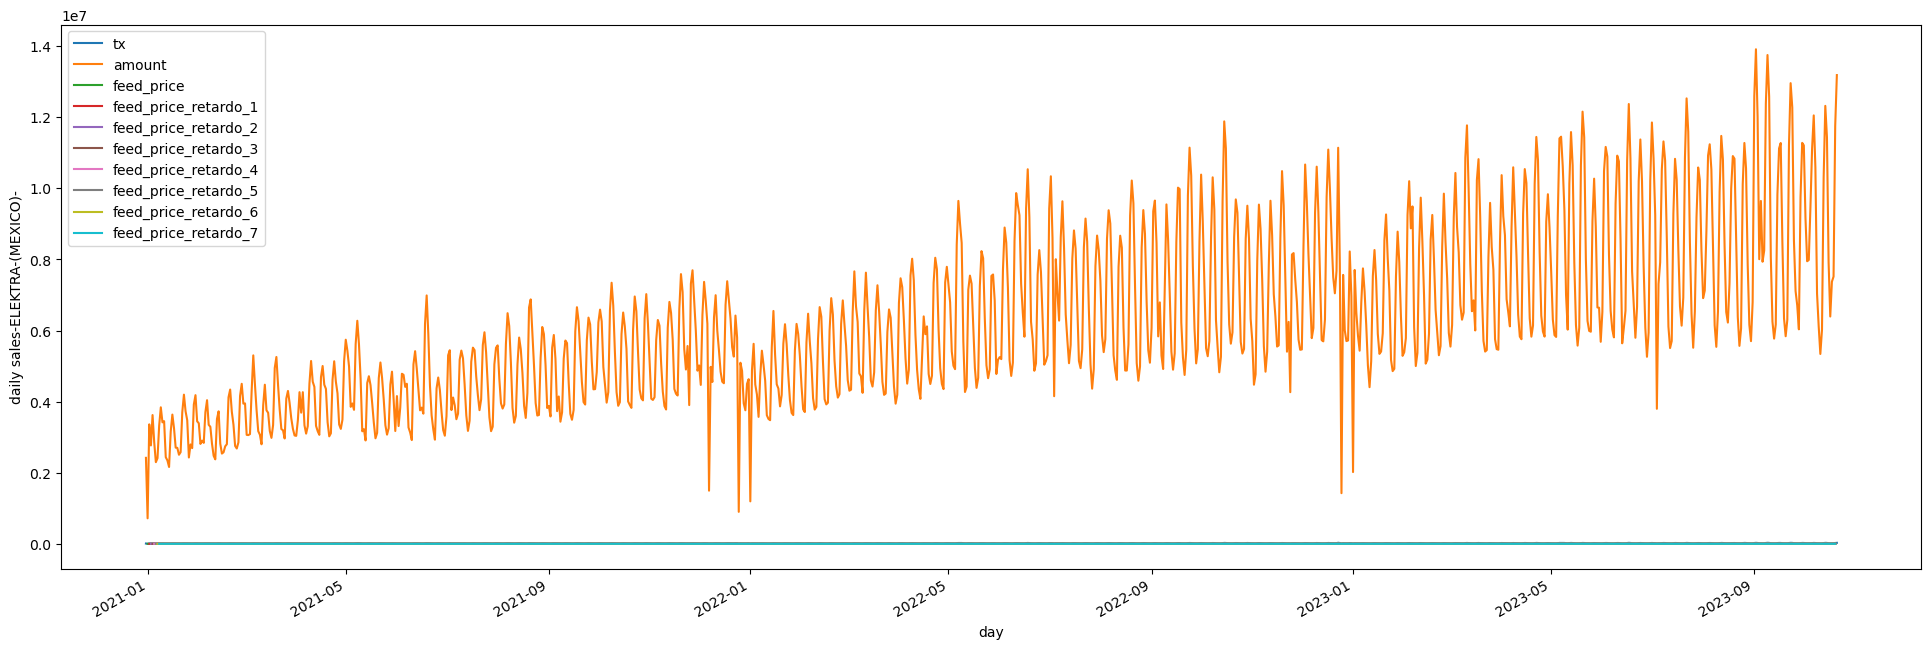

In [33]:
ax = df_pilot.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

In [34]:
##TIME SERIES FORMAT
data = df_pilot
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

/tmp/ipykernel_5222/2650643092.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.DatetimeIndex(data['date'])


In [35]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
data=data.loc[:,['amount']]

In [36]:
data = data.sort_values(by='date')

In [37]:
data.head(3)

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85


In [38]:
##WE DECOMPOSE THE SERIES INTO TREND, SEASONALITY AND RESIDUALS

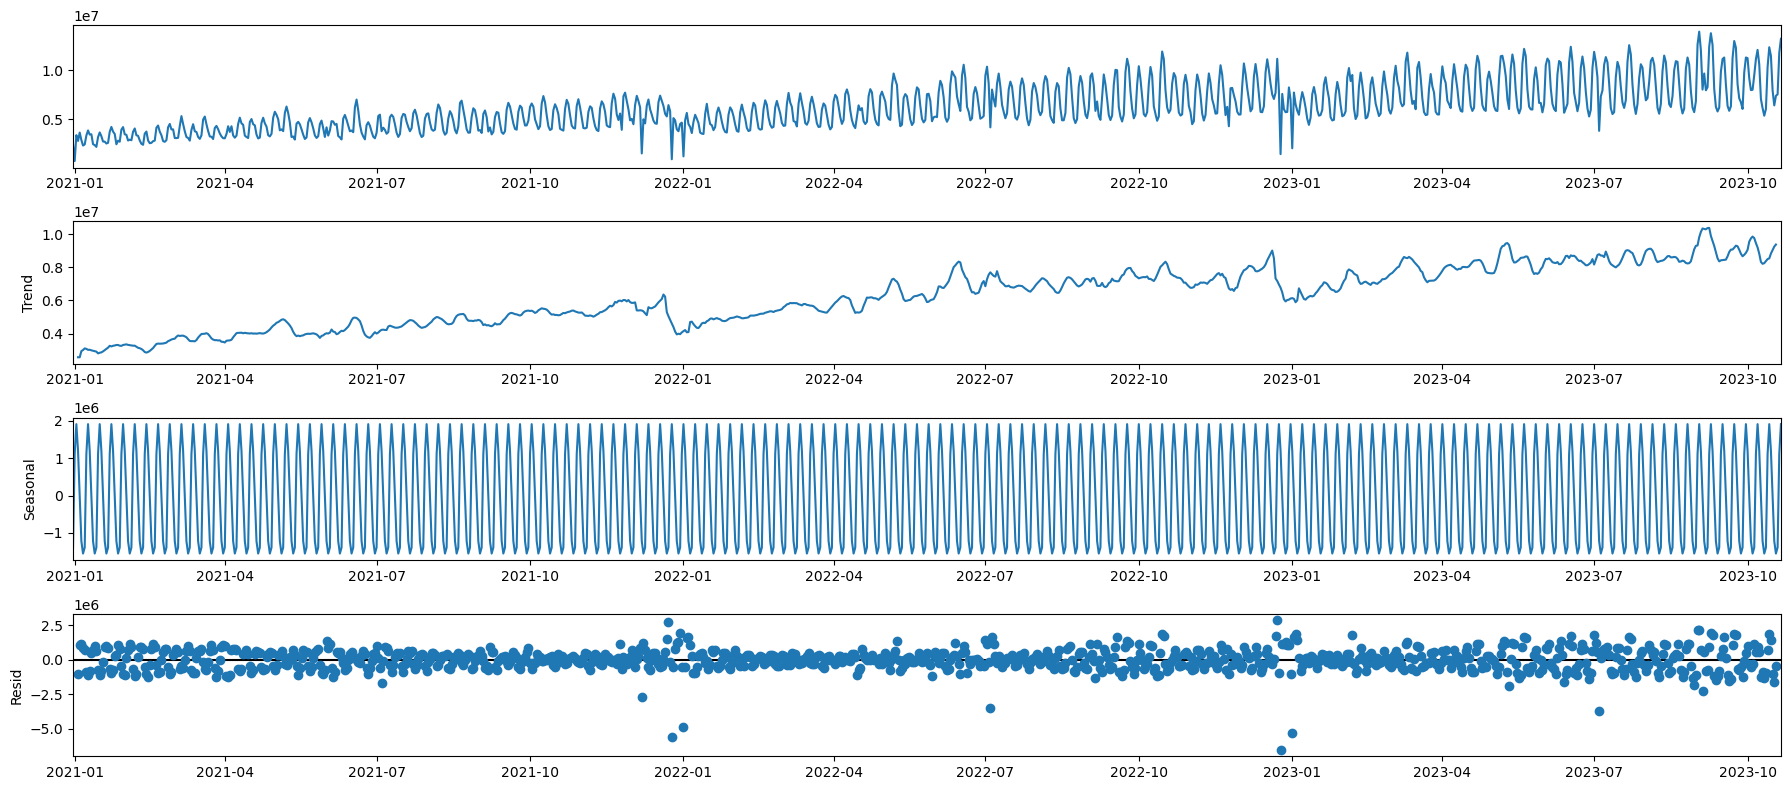

In [39]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [40]:
##STATIONARITY TESTS AUTOCORRELATION GRAPHS
##NON-STATIONARY SERIES##
##The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. 
##If the pvalue is above a critical size, then we cannot reject that there is a unit root.
##In this case (ELEKTRA MÉXICO) we check that the series is non-stationary (0.58>0.05)

ADF Statistic: -1.391752
p-value: 0.586224
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


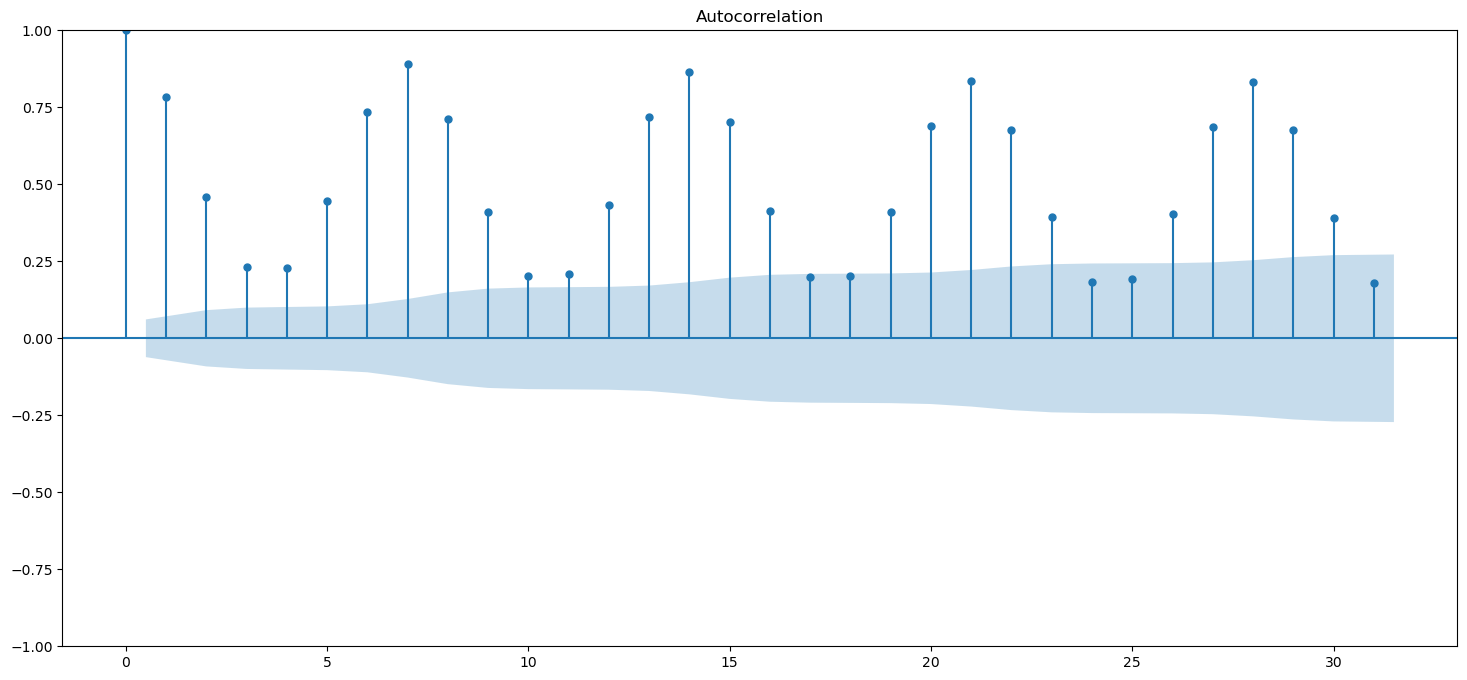

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["amount"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

plot_acf(data)
plt.show()

In [42]:
##PARTIAL AUTOCORRELATION##
##CORRELATION IN SALES AT TIME K AND K-NLAGS BACKWARDS
##EVEN LAG 14 SEEMS TO EXPLAIN TODAY'S AMOUNT (ELEKTRA CASE).
from statsmodels.graphics.tsaplots import plot_pacf

In [43]:
##ARIMA PARAMETER SEARCH##

In [44]:
##SPLIT THE DATABASE INTO TRAIN AND TEST (WITH THE DATABASE SORTED TEMPORALLY)##

In [45]:
traindata = data[0:800] #data[0:800]
traindata.index

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2023-03-01', '2023-03-02', '2023-03-03', '2023-03-04',
               '2023-03-05', '2023-03-06', '2023-03-07', '2023-03-08',
               '2023-03-09', '2023-03-10'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [46]:
testdata = data[801:1025] #data[801:1025]
testdata.index

DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15',
               '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19',
               '2023-10-20', '2023-10-21'],
              dtype='datetime64[ns]', name='date', length=224, freq=None)

In [47]:
traindata.shape, testdata.shape

((800, 1), (224, 1))

In [48]:
##WE INSTALL A TIME SERIES LIBRARY THAT HELPS US TO SELECT THE BEST ARIMA MODEL AUTOMATICALLY##
#!pip install pmdarima

In [49]:
##WE APPLY THE AUTOARIMA MODULE THAT SELECTS THE BEST MODEL FROM AMONG SEVERAL CANDIDATES
## BASED ON THE AUTOCORRELATION GRAPH, WE OBSERVE THAT VALUES OF UP TO 14 LAGS CAN AFFECT TODAY'S AMOUNT. WHICH IMPLIES P AND Q MAX=14 (ALWAYS TAKE CARE OF MODEL PARSIMONY).

In [50]:
# Import the library, require install and restart, uncomment to use
from pmdarima import auto_arima 

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function  dataset 
# Adjusts the best arima model by looking for the one that minimizes the Akaike criterion (AIC)
stepwise_fit = auto_arima(traindata['amount'], start_p = 1, start_q = 1, 
                          max_p = 14, max_q = 14, m = 7 , 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
#p:The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values.
#d:The degree of differencing.
#q:The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=23673.304, Time=0.50 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=24060.954, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=23774.062, Time=0.32 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=23714.935, Time=0.35 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=24061.270, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=23856.346, Time=0.27 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=23645.152, Time=0.54 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=23775.256, Time=0.63 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=23644.235, Time=1.66 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=23726.563, Time=1.02 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=23642.408, Time=2.49 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=23642.666, Time=1.71 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=23692.049, Time=2.54 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=23642.579, Time=1.91 sec
 ARIMA(2,0,1)(2,1,2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  800
Model:             SARIMAX(4, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11810.856
Date:                                Fri, 05 Jan 2024   AIC                          23641.711
Time:                                        13:04:17   BIC                          23688.469
Sample:                                    12-31-2020   HQIC                         23659.681
                                         - 03-10-2023                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    2.33e+04   9579.037      2.433      0.015    4529.511    4.21e+04
ar.L1          0.5313      0.021     24.824      0.000       0.489       0.573
ar.L2         -0.0319      0.038     -0.835      0.404      -0.107       0.043
ar.L3          0.0272      0.067      0.405      0.685      -0.104       0.159
ar.L4          0.0661      0.066      1.000      0.317      -0.063       0.196
ar.S.L7       -0.6055      0.199     -3.050      0.002      -0.995      -0.216
ar.S.L14       0.2330      0.096      2.434      0.015       0.045       0.421
ma.S.L7        0.0077      0.193      0.040      0.968      -0.370       0.386
ma.S.L14      -0.8119      0.185     -4.396      0.000      -1.174      -0.450
sigma2      6.647e+11      0.001   6.02e+14      0.000    6.65e+11    6.65e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19315.70
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               5.05   Skew:                            -2.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.17e+29. Standard errors may be unstable.
"""

In [51]:
##IGNORE THIS CELL FOR NOW
# Manual grid search
# import itertools
# q = d = range(0, 2)
# p=range(0, 3)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

In [52]:
##WE ASSIGN A TIME INDEX 
traindata.index = pd.DatetimeIndex(traindata.index.values,
                               freq=traindata.index.inferred_freq)

In [53]:
##WE ESTIMATE THE BEST MODEL SUGGESTED BY AUTO_ARIMA WITH THE SARIMAX MODULE (P=4,I=0,Q=0) (p=2,i=1,q=2,7-seven to indicate weekly seasonality-)
## FURTHERMORE, ADDITIONAL ESTIMATION CONTROLS ARE PRESENTED.
mod = sm.tsa.statespace.SARIMAX(traindata['amount'],  
                order = (4, 0, 0),  
                seasonal_order =(2, 1, 2, 7))  

results = mod.fit()
print(results.summary().tables[1])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47863D+01    |proj g|=  5.31490D-02


 This problem is unconstrained.



At iterate    5    f=  1.47717D+01    |proj g|=  2.06585D-03

At iterate   10    f=  1.47717D+01    |proj g|=  1.55336D-03

At iterate   15    f=  1.47712D+01    |proj g|=  7.01247D-03

At iterate   20    f=  1.47709D+01    |proj g|=  2.05044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     24     29      1     0     0   2.402D-05   1.477D+01
  F =   14.770905389976040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.

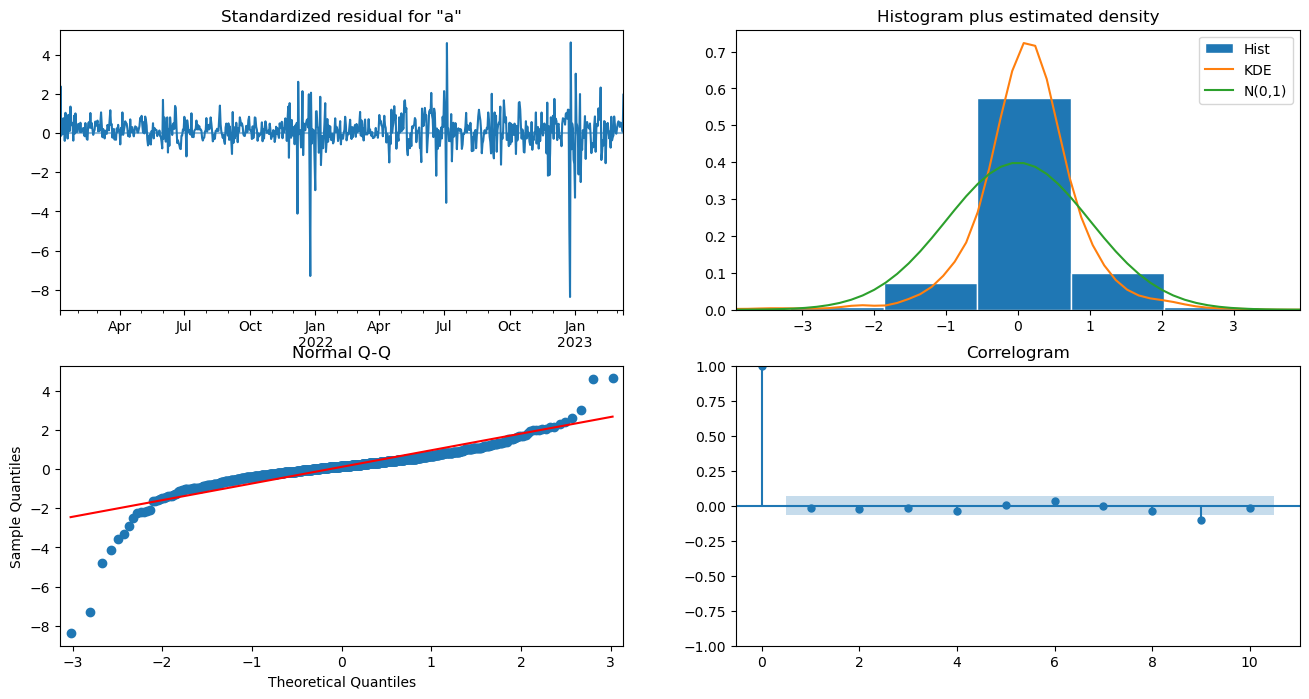

In [54]:
###NOTE THAT THERE ARE SOME DAYS WITH STRONG DEVIATIONS (DEC. 25, JAN. 1)
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [55]:
##WE NOW GENERATE THE FORECAST WITH THE ESTIMATED MODEL WITH THE TEST DATASET
pred = results.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False)
pred_test = pred.conf_int()
res = pred.predicted_mean
pred_test["result"] = pred.predicted_mean
pred_test["y"] = testdata
print("pred_test:\n", pred_test)

pred_test:
             lower amount  upper amount        result             y
2023-03-12  7.100951e+06  1.073576e+07  8.918357e+06  9.990582e+06
2023-03-13  6.246968e+06  9.980507e+06  8.113738e+06  7.865035e+06
2023-03-14  4.672313e+06  8.444561e+06  6.558437e+06  6.543219e+06
2023-03-15  4.081997e+06  7.899706e+06  5.990851e+06  6.847888e+06
2023-03-16  4.249192e+06  8.096039e+06  6.172616e+06  6.002096e+06
2023-03-17  7.632976e+06  1.149380e+07  9.563389e+06  1.023570e+07
2023-03-18  8.133404e+06  1.229423e+07  1.021382e+07  1.082097e+07
2023-03-19  6.396106e+06  1.065208e+07  8.524091e+06  9.213543e+06
2023-03-20  5.553807e+06  9.838331e+06  7.696069e+06  7.104772e+06
2023-03-21  4.045298e+06  8.342450e+06  6.193874e+06  5.707731e+06
2023-03-22  3.625249e+06  7.934425e+06  5.779837e+06  5.407997e+06
2023-03-23  3.896483e+06  8.213189e+06  6.054836e+06  5.449343e+06
2023-03-24  7.051404e+06  1.137190e+07  9.211654e+06  8.071606e+06
2023-03-25  7.698854e+06  1.209605e+07  9.897452e+

In [56]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test["ae"] = abs(pred_test["y"]-pred_test["result"])
mae = pred_test["ae"].mean() 
print("mae:", mae)
mse = ((pred_test["y"]-pred_test["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test["pe"] = abs((pred_test["y"]-pred_test["result"]) / pred_test["y"])
mape = pred_test["pe"].mean() 
print("mape:", mape)

mae: 466039.3773934761
rmse: 564863.8102899819
mape: 0.06250582713403734


In [57]:
##MAPE=6.25% CON MODELO BASE SIN EXÓGENAS##

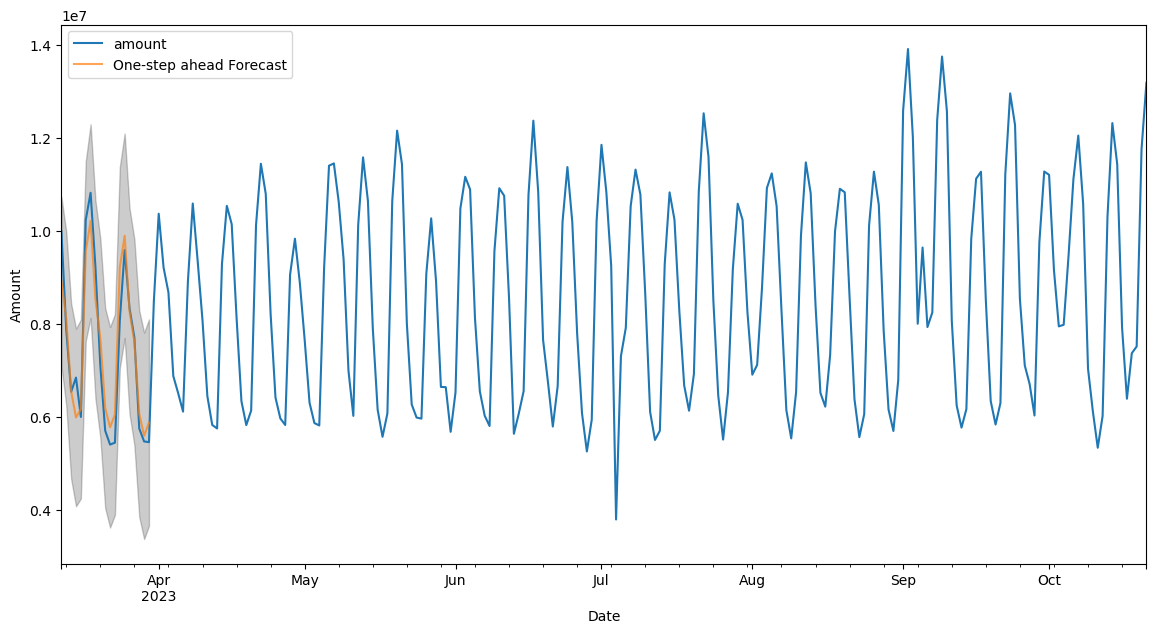

In [58]:
###GENERATE THE CONFIDENCE BANDS OF THE ESTIMATES (LOWER AND UPPER LIMIT) AND PLOT THE PREDICTED VALUE VS. THE ACTUAL VALUE

pred_ci = pred.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred.predicted_mean

ax = testdata.plot(label='observed')
#ax = traindata.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [59]:
##WE NOW INCORPORATE THE EXCHANGE RATE LAGS AS PREDICTORS OF THE EXCHANGE RATE##

In [106]:
### RATES ###
df_rates=pd.read_csv('rates_completo.csv') # CHEQUEAR FUENTE DE ORIGEN

In [107]:
# Selecting columns & renaming
df_rates = df_rates[['feed_date','symbol','feed_price']] 
df_rates = df_rates.rename(columns={'feed_date':'date'})

In [108]:
df_rates['date'] = pd.to_datetime(df_rates['date'])

In [109]:
# Function to keep last register, per day

def get_closing_prices(data, start_date, end_date):
    # Convert the 'FEED_DATE' column to datetime type if it is not already
    data['date'] = pd.to_datetime(data['date'])

    # Filter by date range
    data_filtered = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

    # Sort by 'FEED_DATE' to ensure that the data is in chronological order
    data_filtered = data_filtered.sort_values(by='date')

    # Group by 'SYMBOL' and 'FEED_DATE', taking the last value of 'FEED_PRICE'
    data_grouped = data_filtered.groupby(['symbol', pd.Grouper(key='date', freq='D')])['feed_price'].last().reset_index()
    
    return data_grouped

In [110]:
start_date = '2021-01-01'
end_date = '2023-10-21'

rates = get_closing_prices(df_rates, start_date, end_date)

In [111]:
rates

,symbol,date,feed_price
0,USDBRL,2021-01-01,5.1934
1,USDBRL,2021-01-02,5.1934
2,USDBRL,2021-01-03,5.1975
3,USDBRL,2021-01-04,5.2972
4,USDBRL,2021-01-05,5.2855
...,...,...,...
5110,USDPHP,2023-10-16,56.6998
5111,USDPHP,2023-10-17,56.6960
5112,USDPHP,2023-10-18,56.8562
5113,USDPHP,2023-10-19,56.7388


In [125]:
# Generating an empty df with date continuity and currency included in rates df
from itertools import product

def generate_continuous_dates(data):
    # Obtener la lista única de monedas y fechas disponibles
    countries = data['symbol'].unique()
    dates = pd.date_range(start=data['date'].min(), end=data['date'].max(), freq='D')

    # Generar todas las combinaciones de países y fechas continuas
    all_dates = list(product(countries, dates))
    continuous_dates = pd.DataFrame(all_dates, columns=['symbol', 'date'])

    return continuous_dates

In [126]:
rates_cont = generate_continuous_dates(rates)

In [127]:
rates_cont = pd.merge(rates_cont, rates, on=['symbol', 'date'], how='left')

In [131]:
# Sorting by date and country for proper forward filling
rates_cont = rates_cont.sort_values(by=['symbol', 'date'])
# Filling missing values downward within each country group
rates_cont['feed_price'] = rates_cont.groupby('symbol')['feed_price'].fillna(method='ffill')

In [132]:
###WE OBTAIN THE LAGS OF UP TO 7 DAYS FOR THE EXCHANGE RATE 
for i in range(1, 8):
        nombre_columna = f'feed_price_retardo_{i}'
        rates_cont[nombre_columna] = rates_cont['feed_price'].shift(i)

In [133]:
rates_cont['var_rate_lag1']=rates_cont.feed_price_retardo_1-rates_cont.feed_price_retardo_2
rates_cont['var_rate_lag2']=rates_cont.feed_price_retardo_2-rates_cont.feed_price_retardo_3
rates_cont['var_rate_lag3']=rates_cont.feed_price_retardo_3-rates_cont.feed_price_retardo_4
rates_cont['var_rate_lag4']=rates_cont.feed_price_retardo_4-rates_cont.feed_price_retardo_5
rates_cont['var_rate_lag5']=rates_cont.feed_price_retardo_5-rates_cont.feed_price_retardo_6
rates_cont['var_rate_lag6']=rates_cont.feed_price_retardo_6-rates_cont.feed_price_retardo_7

In [134]:
# Filling NaN
rates_cont=rates_cont.fillna(method='bfill')
rates_cont=rates_cont.fillna(method='ffill')

In [119]:
rates_cont.head()

,symbol,date,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
0,USDBRL,2021-01-01,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,0.0000,0.0000,0.0,0.0,0.0,0.0
1,USDBRL,2021-01-02,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,0.0000,0.0000,0.0,0.0,0.0,0.0
2,USDBRL,2021-01-03,5.1975,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,0.0000,0.0000,0.0,0.0,0.0,0.0
3,USDBRL,2021-01-04,5.2972,5.1975,5.1934,5.1934,5.1934,5.1934,5.1934,5.1934,0.0041,0.0000,0.0,0.0,0.0,0.0
4,USDBRL,2021-01-05,5.2855,5.2972,5.1975,5.1934,5.1934,5.1934,5.1934,5.1934,0.0997,0.0041,0.0,0.0,0.0,0.0


In [135]:
rates_mex = rates_cont[rates_cont['symbol'] == 'USDMXN']

In [136]:
rates_mex.set_index('date', inplace=True)

In [137]:
rates_mex.head()

,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,,,
2021-01-01,USDMXN,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,83.2646,83.2795,0.0911,-0.1183,0.0222,0.0430,-0.0630,-0.0149
2021-01-02,USDMXN,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,83.2646,-63.3574,0.0911,-0.1183,0.0222,0.0430,-0.0630
2021-01-03,USDMXN,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,0.0000,-63.3574,0.0911,-0.1183,0.0222,0.0430
2021-01-04,USDMXN,19.9046,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,-0.0540,0.0000,-63.3574,0.0911,-0.1183,0.0222
2021-01-05,USDMXN,19.9196,19.9046,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,0.0764,-0.0540,0.0000,-63.3574,0.0911,-0.1183


In [138]:
merged_mex = data.merge(rates_mex, left_index=True, right_index=True)

In [139]:
merged_mex

,amount,symbol,feed_price,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,,,,
2021-01-01,717241.42,USDMXN,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,83.2646,83.2795,0.0911,-0.1183,0.0222,0.0430,-0.0630,-0.0149
2021-01-02,3360407.85,USDMXN,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,83.2646,-63.3574,0.0911,-0.1183,0.0222,0.0430,-0.0630
2021-01-03,2767481.77,USDMXN,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,0.0000,-63.3574,0.0911,-0.1183,0.0222,0.0430
2021-01-04,3621953.17,USDMXN,19.9046,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,-0.0540,0.0000,-63.3574,0.0911,-0.1183,0.0222
2021-01-05,2862477.96,USDMXN,19.9196,19.9046,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,0.0764,-0.0540,0.0000,-63.3574,0.0911,-0.1183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-16,7920331.42,USDMXN,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358,18.2011,-0.0465,0.0000,0.1339,0.1237,-0.1021,-0.2653
2023-10-17,6394084.62,USDMXN,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358,-0.1329,-0.0465,0.0000,0.1339,0.1237,-0.1021
2023-10-18,7372639.68,USDMXN,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337,0.0975,-0.1329,-0.0465,0.0000,0.1339,0.1237


In [155]:
##TIME SERIES FORMAT
data2 = merged_mex.copy()
data2.dtypes #day object
#data2['date'] = pd.DatetimeIndex(data2['date'])
#df_pilot.dtypes   #Month datetime64[ns]

data2.index  #RangeIndex()
#data2 = data2.set_index('date')

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14',
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20'],
              dtype='datetime64[ns]', name='date', length=1023, freq=None)

In [156]:
##WE ELIMINATE STRING VARIABLES##
data2=merged_mex.loc[:,['amount','feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]

In [157]:
data2

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2021-01-01,717241.42,83.2396,83.1485,83.2668,83.2446,83.2016,83.2646,83.2795
2021-01-02,3360407.85,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016,83.2646
2021-01-03,2767481.77,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446,83.2016
2021-01-04,3621953.17,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668,83.2446
2021-01-05,2862477.96,19.9046,19.8282,19.8822,19.8822,83.2396,83.1485,83.2668
...,...,...,...,...,...,...,...,...
2023-10-16,7920331.42,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358,18.2011
2023-10-17,6394084.62,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358
2023-10-18,7372639.68,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337


In [158]:
from datetime import datetime
datetime.strptime('2023-10-20', '%Y-%m-%d') - datetime.strptime('2021-01-01', '%Y-%m-%d')

datetime.timedelta(days=1022)

In [159]:
stepwise_fit = auto_arima(traindata['amount'], exogenous = data2,
                          start_p=1, start_q=1, max_p=14, max_q=14, m=7,
                          start_P=0, seasonal=True, d=None, D=1,
                          trace=True, error_action='ignore',
                          suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=23673.304, Time=0.51 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=24060.954, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=23774.062, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=23714.935, Time=0.41 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=24061.270, Time=0.04 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=23856.346, Time=0.21 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=23645.152, Time=0.51 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=23775.256, Time=0.45 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=23644.235, Time=1.69 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=23726.563, Time=0.99 sec
 ARIMA(1,0,1)(2,1,2)[7] intercept   : AIC=23642.408, Time=2.40 sec
 ARIMA(1,0,1)(1,1,2)[7] intercept   : AIC=23642.666, Time=1.68 sec
 ARIMA(0,0,1)(2,1,2)[7] intercept   : AIC=23692.049, Time=2.56 sec
 ARIMA(1,0,0)(2,1,2)[7] intercept   : AIC=23642.579, Time=1.88 sec
 ARIMA(2,0,1)(2,1,2

In [84]:
##SARIMAX PARAMETER SEARCH##

In [162]:
traindata2 = data2[0:800] #data[0:800]
traindata2=traindata2.loc[:,['amount', 'feed_price_retardo_1', 'feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]
traindata2.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05',
               '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',
               '2023-03-10', '2023-03-11'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [169]:
testdata2 = data2[800:1025] #data[801:1025]
testdata2=testdata2.loc[:,['amount', 'feed_price_retardo_1','feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']]
testdata2.index


DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14',
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20'],
              dtype='datetime64[ns]', name='date', length=223, freq=None)

In [170]:
traindata2.shape, testdata2.shape

((800, 8), (223, 8))

In [172]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

traindata2=traindata2.fillna(method='bfill')
testdata2=testdata2.fillna(method='bfill')
traindata2=traindata2.fillna(method='ffill')
testdata2=testdata2.fillna(method='ffill')
exog=['feed_price_retardo_1','feed_price_retardo_2', 'feed_price_retardo_3', 'feed_price_retardo_4', 'feed_price_retardo_5', 'feed_price_retardo_6', 'feed_price_retardo_7']
mod = sm.tsa.SARIMAX(traindata2[['amount']], order=(4,0,0), seasonal_order =(2, 1, 2, 7), exog=traindata2[exog])
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  800
Model:             SARIMAX(4, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11813.147
Date:                                Fri, 05 Jan 2024   AIC                          23658.294
Time:                                        13:48:48   BIC                          23733.108
Sample:                                    01-01-2021   HQIC                         23687.046
                                         - 03-11-2023                                         
Covariance Type:                                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
feed_price_retardo_1 -1.277e+04   8.99e+04     -0.142      0.8

In [173]:
testdata2.tail()

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7
date,,,,,,,,
2023-10-16,7920331.42,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358,18.2011
2023-10-17,6394084.62,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337,17.9358
2023-10-18,7372639.68,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574,17.8337
2023-10-19,7517141.00,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574
2023-10-20,11755749.86,18.3207,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913


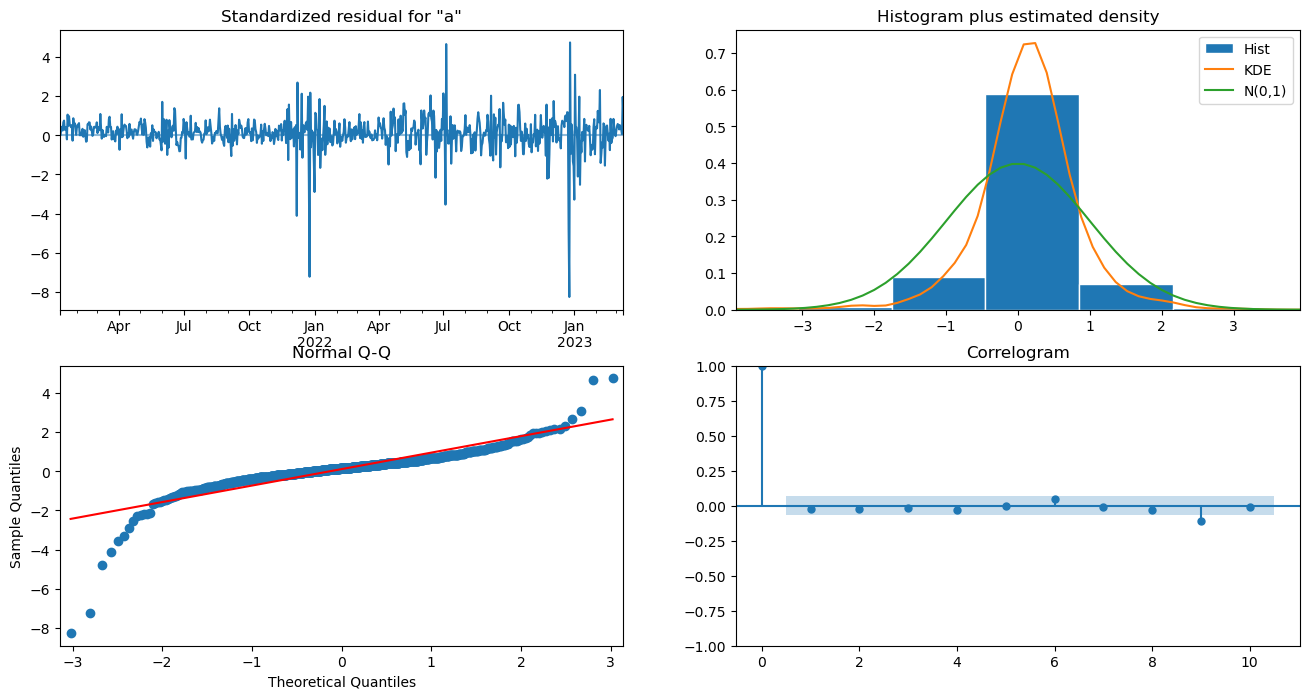

In [174]:
res.plot_diagnostics(figsize=(16, 8))
plt.show()

In [183]:
testdata2=testdata2[0:20]
pred2 = res.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-31'), dynamic=False, exog=testdata2[exog])
pred_test2 = pred2.conf_int()
res2 = pred2.predicted_mean
pred_test2["result"] = pred2.predicted_mean
pred_test2["y"] = testdata2['amount']
print("pred_test2:\n", pred_test2)

pred_test2:
             lower amount  upper amount        result             y
2023-03-12  7.777534e+06  1.097553e+07  9.376533e+06  9.990582e+06
2023-03-13  6.504709e+06  1.017050e+07  8.337602e+06  7.865035e+06
2023-03-14  4.813318e+06  8.580200e+06  6.696759e+06  6.543219e+06
2023-03-15  4.245812e+06  8.053885e+06  6.149848e+06  6.847888e+06
2023-03-16  4.361212e+06  8.215630e+06  6.288421e+06  6.002096e+06
2023-03-17  7.705546e+06  1.159009e+07  9.647820e+06  1.023570e+07
2023-03-18  8.657954e+06  1.255694e+07  1.060745e+07  1.082097e+07
2023-03-19  6.648705e+06  1.084518e+07  8.746941e+06  9.213543e+06
2023-03-20  5.673138e+06  9.969655e+06  7.821397e+06  7.104772e+06
2023-03-21  4.109227e+06  8.434888e+06  6.272058e+06  5.707731e+06
2023-03-22  3.690420e+06  8.029326e+06  5.859873e+06  5.407997e+06
2023-03-23  3.939936e+06  8.291079e+06  6.115507e+06  5.449343e+06
2023-03-24  7.076999e+06  1.143589e+07  9.256443e+06  8.071606e+06
2023-03-25  7.931798e+06  1.229459e+07  1.011319e

In [184]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test2["ae"] = abs(pred_test2["y"]-pred_test2["result"])
mae = pred_test2["ae"].mean() 
print("mae:", mae)
mse = ((pred_test2["y"]-pred_test2["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test2["pe"] = abs((pred_test2["y"]-pred_test2["result"]) / pred_test2["y"])
mape = pred_test2["pe"].mean() 
print("mape:", mape)

mae: 465203.0021407686
rmse: 534167.7965069643
mape: 0.06467944229308473


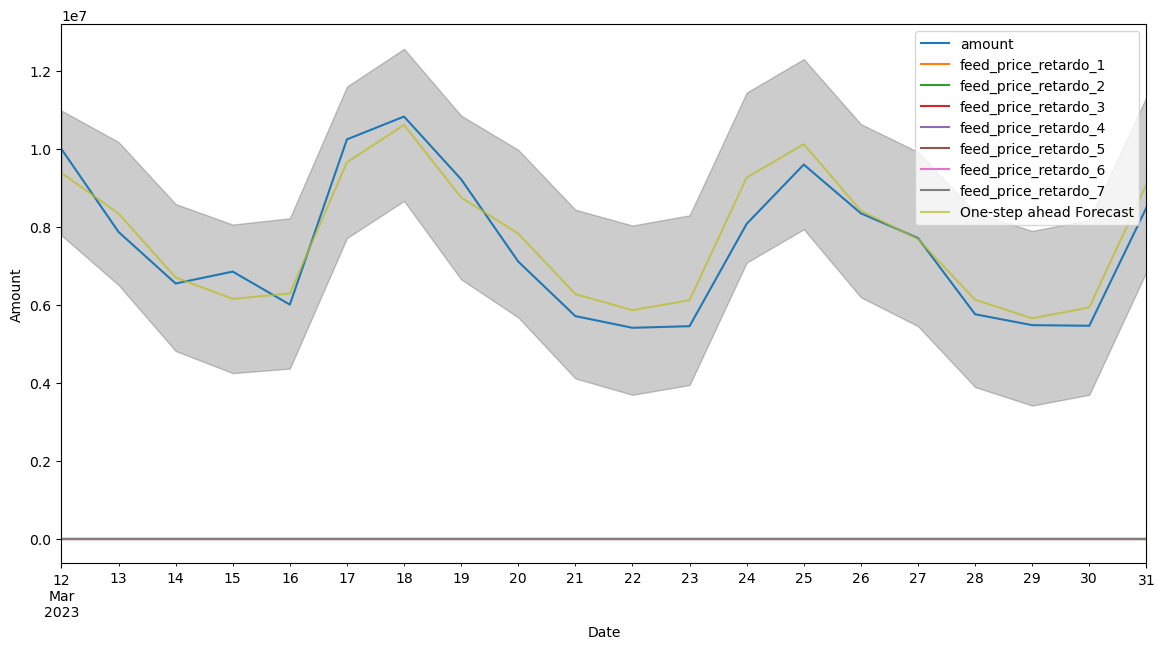

In [185]:
pred_ci2 = pred2.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred2.predicted_mean

ax = testdata2.plot(label='observed')
#ax = traindata.plot(label='observed')
pred2.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [ ]:
##SAME APPROACH BUT WORKING WITH DAILY EXCHANGE RATE DIFFERENCES

In [186]:
data3=data2.copy()

In [187]:
data3=data3.fillna(method='bfill')
data3=data3.fillna(method='ffill')

In [188]:
data3['var_rate_lag1']=data3.feed_price_retardo_1-data3.feed_price_retardo_2
data3['var_rate_lag2']=data3.feed_price_retardo_2-data3.feed_price_retardo_3
data3['var_rate_lag3']=data3.feed_price_retardo_3-data3.feed_price_retardo_4
data3['var_rate_lag4']=data3.feed_price_retardo_4-data3.feed_price_retardo_5
data3['var_rate_lag5']=data3.feed_price_retardo_5-data3.feed_price_retardo_6
data3['var_rate_lag6']=data3.feed_price_retardo_6-data3.feed_price_retardo_7
data3.tail(2)

,amount,feed_price_retardo_1,feed_price_retardo_2,feed_price_retardo_3,feed_price_retardo_4,feed_price_retardo_5,feed_price_retardo_6,feed_price_retardo_7,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,,,,,,,,
2023-10-19,7517141.00,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,17.9574,0.2632,0.0975,-0.1329,-0.0465,0.0000,0.1339
2023-10-20,11755749.86,18.3207,18.2726,18.0094,17.9119,18.0448,18.0913,18.0913,0.0481,0.2632,0.0975,-0.1329,-0.0465,0.0000


In [189]:
##WE ELIMINATE SOME VARIABLES##
data3=data3.loc[:,['amount', 'var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6']]
data3.tail()

,amount,var_rate_lag1,var_rate_lag2,var_rate_lag3,var_rate_lag4,var_rate_lag5,var_rate_lag6
date,,,,,,,
2023-10-16,7920331.42,-0.0465,0.0000,0.1339,0.1237,-0.1021,-0.2653
2023-10-17,6394084.62,-0.1329,-0.0465,0.0000,0.1339,0.1237,-0.1021
2023-10-18,7372639.68,0.0975,-0.1329,-0.0465,0.0000,0.1339,0.1237
2023-10-19,7517141.00,0.2632,0.0975,-0.1329,-0.0465,0.0000,0.1339
2023-10-20,11755749.86,0.0481,0.2632,0.0975,-0.1329,-0.0465,0.0000


In [ ]:
##SARIMAX PARAMETER SEARCH##

In [190]:
traindata3 = data3[0:800] #data[0:800]
traindata3.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2023-03-02', '2023-03-03', '2023-03-04', '2023-03-05',
               '2023-03-06', '2023-03-07', '2023-03-08', '2023-03-09',
               '2023-03-10', '2023-03-11'],
              dtype='datetime64[ns]', name='date', length=800, freq=None)

In [192]:
testdata3 = data3[800:1025] #data[801:1025]
testdata3.index

DatetimeIndex(['2023-03-12', '2023-03-13', '2023-03-14', '2023-03-15',
               '2023-03-16', '2023-03-17', '2023-03-18', '2023-03-19',
               '2023-03-20', '2023-03-21',
               ...
               '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14',
               '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18',
               '2023-10-19', '2023-10-20'],
              dtype='datetime64[ns]', name='date', length=223, freq=None)

In [193]:
traindata3.shape, testdata3.shape

((800, 7), (223, 7))

In [198]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6']
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(4,0,0), seasonal_order =(2, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                 amount   No. Observations:                  800
Model:             SARIMAX(4, 0, 0)x(2, 1, [1, 2], 7)   Log Likelihood              -11813.327
Date:                                Fri, 05 Jan 2024   AIC                          23656.654
Time:                                        13:53:33   BIC                          23726.791
Sample:                                    01-01-2021   HQIC                         23683.609
                                         - 03-11-2023                                         
Covariance Type:                                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
var_rate_lag1    1.3e+04   2.94e+04      0.442      0.659   -4.47e+04    7.0

In [203]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

AttributeError: 'Series' object has no attribute 'plot_diagnostics'

In [202]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-31'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

AttributeError: 'Series' object has no attribute 'get_prediction'

In [204]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)

mae: 462691.8419530677
rmse: 531200.8655417105
mape: 0.06440608076633382


In [ ]:
##MAPE BAJA DESDE 6.25% A 5.88% CON REZAGOS DE VARIACIONES DEL TIPO DE CAMBIO#
## Y TENER EN CUENTA QUE AÚN NO ENCONTRAMOS LA FORMA DE ENTRENAR CON EXÓGENAS CON AUTOARIMA
## VAMOS A ESTUDIAR LA LIBRERIA SKFORECAST QUE SUPUESTAMENTE PERMITE ENCONTRAR EL MEJOR MODELO CON AUTOARIMA Y EXOGENAS

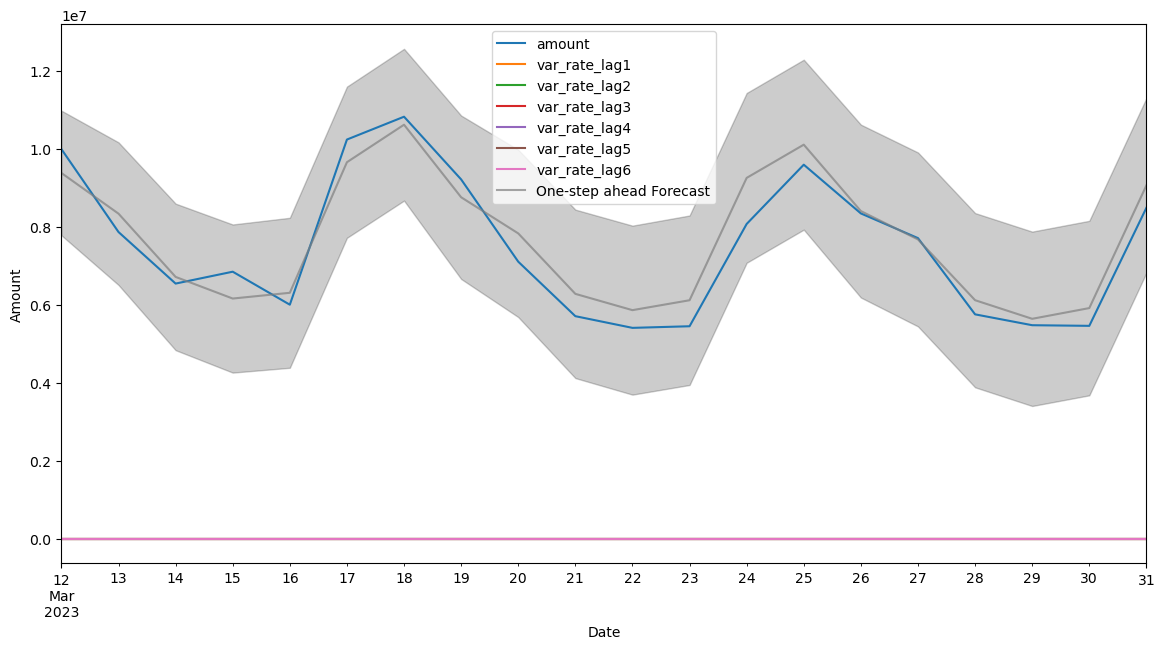

In [205]:
pred_ci3 = pred3.conf_int()

#print("conf_int:", pred_ci)
#print("mean:", pred.predicted_mean)
p = pred3.predicted_mean

ax = testdata3.plot(label='observed')
#ax = traindata.plot(label='observed')
pred3.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci3.index,
                pred_ci3.iloc[:, 0],
                pred_ci3.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Amount')
plt.legend()

plt.show()

In [ ]:
###NOW WE TEST CANCELLATIONS###

In [206]:
# DB Setting
bucket_name = 's3://viamericas-datalake-dev-us-east-1-283731589572-athena/'
origin_name = 'AwsDataCatalog'
database_name = 'viamericas'
database_name2= 'analytics'
table1_name = 'forex_feed_market'
table2_name = 'daily_sales_count_cancelled_v2'##WE LOAD THE BASE WITH CANCELLATIONS

In [207]:
#Connection
conn = connect(s3_staging_dir=f'{bucket_name}queryresults/',
               region_name='us-east-1')
#df1 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name}.{table1_name};', conn)
df3 = pd.read_sql(f'SELECT * FROM {origin_name}.{database_name2}.{table2_name};', conn)

In [ ]:
df3.shape

In [ ]:
##WE NEED TO GO ONE STEP BACK, AND BEFORE GROUPING THE AMOUNT BY COUNTRY DATE AND PAYER, COUNT THE CANCELLATIONS (GENERATE THE TABLE IN ATHENA)

In [ ]:
df3.head()

In [ ]:
##FILTERING MEXICO##

In [208]:
df_montos_mex2=df3.loc[df3.country=='MEXICO']

In [209]:
df_montos_mex2.amount.sum()

13655009099.176899

In [210]:
##AS PART OF A PILOT TEST WE WILL ONLY WORK WITH ONE PAYER, AND THEN WE WILL GENERALIZE THE ROUTINE##
## WE WILL NOW FIT A MODEL WITH LAGS OF THE CANCELLATIONS (SARIMAX) TO SEE IF IT PERFORMS BETTER THAN THE SIMPLE ARIMA MODEL.
##WE START WITH ELEKTRA AND THE CASE WITHOUT EXOGENOUS VARIABLES ##
df_pilot4=df_montos_mex2.loc[df_montos_mex2.payer=='ELEKTRA (MEXICO)']
df_pilot4.shape

(1025, 5)

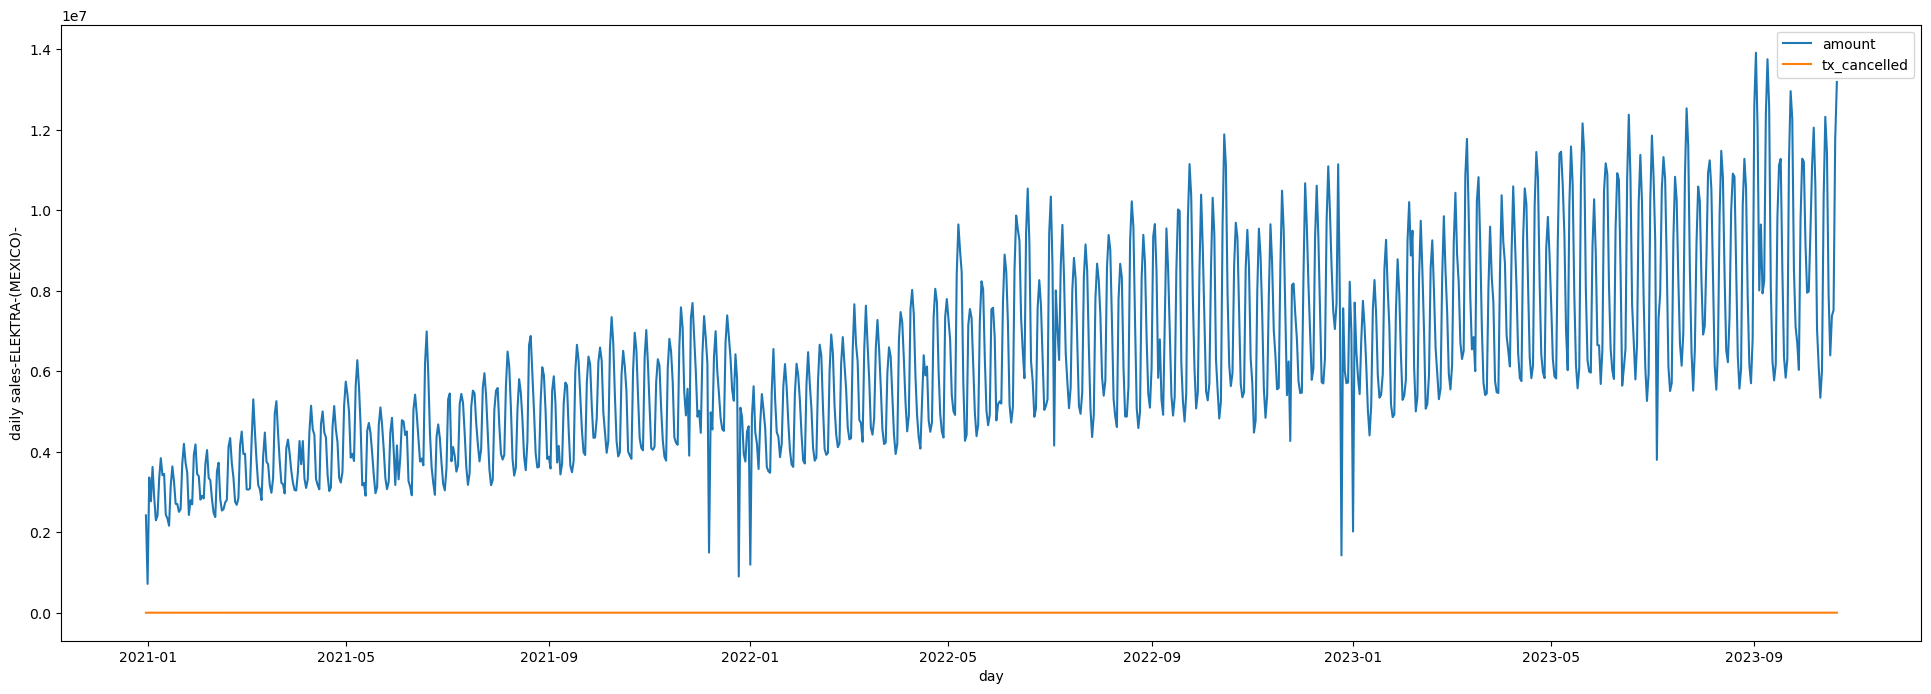

In [211]:
ax = df_pilot4.set_index('date').plot(figsize=(24, 8))
ax.set_ylabel('daily sales-ELEKTRA-(MEXICO)-')
ax.set_xlabel('day')
plt.show()

##TIME SERIES FORMAT
data = df_pilot4
data.dtypes #day object
data['date'] = pd.DatetimeIndex(data['date'])
df_pilot.dtypes   # datetime64[ns]

data.index  #RangeIndex()
data = data.set_index('date')

In [212]:
data = data.sort_values(by='date')
data.head()

,amount
date,
2020-12-31,2418346.71
2021-01-01,717241.42
2021-01-02,3360407.85
2021-01-03,2767481.77
2021-01-04,3621953.17


In [213]:

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['tx_cancelled'], linestyle='-', color='b')

plt.title('Evolución de tx_cancelled a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('tx_cancelled')
plt.grid(True)
plt.show()

KeyError: 'tx_cancelled'

<Figure size 1000x600 with 0 Axes>

In [ ]:
for i in range(1, 8):
        nombre_columna = f'tx_cancelled_{i}'
        data[nombre_columna] = data['tx_cancelled'].shift(i)

In [214]:
##WE ELIMINATE STRING VARIABLES AND OTHER VARIABLES##
##WE ELIMINATE STRING VARIABLES##
data=data.loc[:,['amount', 'tx_cancelled_1', 'tx_cancelled_2', 'tx_cancelled_3', 'tx_cancelled_4', 'tx_cancelled_5', 'tx_cancelled_6', 'tx_cancelled_7']]

KeyError: "['tx_cancelled_1', 'tx_cancelled_2', 'tx_cancelled_3', 'tx_cancelled_4', 'tx_cancelled_5', 'tx_cancelled_6', 'tx_cancelled_7'] not in index"

In [ ]:
data.head()

In [ ]:
data=data.fillna(method='bfill')
data=data.fillna(method='ffill')
data.head()

In [ ]:
##WE DECOMPOSE THE SERIES INTO TREND, SEASONALITY AND RESIDUALS

In [ ]:
data = data.sort_values(by='date')
data.head()

In [ ]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(data['amount'], model='additive', period=None) #multiplicative, additive
fig = decomposition.plot()
plt.show()

In [ ]:
data['var_tx_cancelled_1']=data.tx_cancelled_1-data.tx_cancelled_2
data['var_tx_cancelled_2']=data.tx_cancelled_2-data.tx_cancelled_3
data['var_tx_cancelled_3']=data.tx_cancelled_3-data.tx_cancelled_4
data['var_tx_cancelled_4']=data.tx_cancelled_4-data.tx_cancelled_5
data['var_tx_cancelled_5']=data.tx_cancelled_5-data.tx_cancelled_6
data['var_tx_cancelled_6']=data.tx_cancelled_6-data.tx_cancelled_7
data.tail()

In [ ]:
##WE ELIMINATE SOME VARIABLES##
data=data.loc[:,['amount', 'var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6']]
data.tail()

In [ ]:
##SARIMAX PARAMETER SEARCH##

In [ ]:
traindata3 = data[0:800] #data[0:800]
traindata3.index

In [ ]:
testdata3 = data[800:1025] #data[0:1025]
testdata3.index

In [ ]:
traindata3.shape, testdata3.shape

In [ ]:
traindata3

In [ ]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6']
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(4,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

In [ ]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

In [ ]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)

In [ ]:
##BAJA DE 6.25% A 5.79% RESPECTO DEL MODELO SARIMA SIMPLE Y SIN HABER SIDO OPTIMIZADO (EXPLORAR FORECAST)

In [ ]:
##PROXIMO PASO: ESTIMAR EL ERROR CON LOS DOS GRUPOS DE EXOGENAS JUNTAS(RATES Y CANCELACIONES)##

In [ ]:
data.head()

In [ ]:
data_rates_canc=pd.merge(data,data3, left_index=True, right_index=True, how='left')

In [ ]:
data_rates_canc.head()

In [ ]:
data_rates_canc.info()

In [ ]:
traindata3 = data_rates_canc[0:800] #data[0:800]
traindata3.index

In [ ]:
testdata3 = data_rates_canc[800:1025] #data[0:1025]
testdata3.index

In [ ]:
traindata3.shape, testdata3.shape

In [ ]:
##WE TRY ANOTHER LIBRARY THAT DOES NOT HAVE PROBLEMS IN ADOPTING EXOGENOUS VARIABLES ##

###CLAVE: VER COMO ENTRENAR EL MODELO CON VARS EXOGENAS, NOTAR QUE ARRIBA SE LO ENTRENA CON AUTOARIMA (PROBLEMA, AUTOARIMA NO CAPTA POR ALGUNA RAZON LAS EXOGENAS)

import statsmodels.api as sm

###WE IMPUTE THE MISSING VALUES THAT GENERATE THE DIFFERENCES WITH SUBSEQUENT VALUES CLOSE IN TIME

exog3=['var_tx_cancelled_1', 'var_tx_cancelled_2', 'var_tx_cancelled_3', 'var_tx_cancelled_4', 'var_tx_cancelled_5', 'var_tx_cancelled_6','var_rate_lag1', 'var_rate_lag2', 'var_rate_lag3', 'var_rate_lag4', 'var_rate_lag5', 'var_rate_lag6'] 
mod2 = sm.tsa.SARIMAX(traindata3[['amount']], order=(4,0,0), seasonal_order =(0, 1, 2, 7), exog=traindata3[exog3])
res2 = mod2.fit(maxiter=1000, disp=False)
print(res2.summary())

In [ ]:
res2.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
testdata3=testdata3[0:20]
pred3 = res2.get_prediction(start=pd.to_datetime('2023-03-12'),end=pd.to_datetime('2023-03-30'), dynamic=False, exog=testdata3[exog3])
pred_test3 = pred3.conf_int()
res2 = pred3.predicted_mean
pred_test3["result"] = pred3.predicted_mean
pred_test3["y"] = testdata3['amount']
print("pred_test2:\n", pred_test3)

In [ ]:
#FORECAST PERFORMANCE
##DEFINITIONS:
##The MAPE measures the average percentage error between predictions and actual values.
##The MAE is the arithmetic mean of the absolute errors between predictions and actual values.
##The RMSE measures the root mean square of the root mean square errors between predictions and actual values.
import numpy as np
pred_test3["ae"] = abs(pred_test3["y"]-pred_test3["result"])
mae = pred_test3["ae"].mean() 
print("mae:", mae)
mse = ((pred_test3["y"]-pred_test3["result"])**2).mean()
rmse = np.sqrt(mse)
print("rmse:", rmse)

pred_test3["pe"] = abs((pred_test3["y"]-pred_test3["result"]) / pred_test3["y"])
mape = pred_test3["pe"].mean() 
print("mape:", mape)

In [ ]:
###VA BAJANDO!!!!!!!!! (Y AUN FALTA OPTIMIZARLO CON AUTOARIMA, AGREGAR DUMMIES DE DIAS DE LA SEMANA, FERIADOS ETC###
##NOTAR QUE REDUCE 20% EL MARGEN DE ERROR RESPECTO DEL SARIMA OPTIMIZADO SIN FERIADOS(AL MENOS PARA ESTOS 20 DIAS DE MARZO)##